In [1]:
import sys
sys.path.append("../..")

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
# environments

from environment.deepqlearning.obstacle_avoidance_env import ObstacleAvoidanceEnv

In [4]:
from utils.reader import get_yaml_path, read_file

In [5]:
from utils.plotting import plot_td_losses

In [6]:
from agent.scala_dqagent import DQAgent
from training.dqnetwork import DQNetwork

2025-11-12 18:00:41.026879: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-12 18:00:41.065278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-12 18:00:43.955203: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
from evaluation.agent_evaluation import evaluate

In [8]:
server_address = "localhost:50060" # adjust the port as needed
client_name = "RLClient"
env = ObstacleAvoidanceEnv(server_address, client_name) # adjust the env as needed
env.connect_to_client()

2025-11-12 18:00:44,593 — INFO — ✓ Connected to localhost:50060



In [9]:
configs_path = get_yaml_path("src", "scripts", "resources", "generated", "dq-obstacle-avoidance-test")
yml_files = list(configs_path.glob("*.yml"))
configs = [read_file(f) for f in yml_files]
config = configs[0]
env.init(config)

(True, '')

In [10]:
neuron_count_per_hidden_layer = [64, 32]

In [11]:
agent_id = "00000000-0000-0000-0000-000000000001"
agent = DQAgent(
    env,
    agent_id=agent_id,
    action_model=DQNetwork(
        env.observation_space.shape,
        neuron_count_per_hidden_layer,
        env.action_space.n,
        summary=False,
    ),
    target_model=DQNetwork(
        env.observation_space.shape,
        neuron_count_per_hidden_layer,
        env.action_space.n,
        summary=False,
    ),
)
agents = { agent_id: agent }

2025-11-12 18:00:44.725130: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
print(agent)

In [13]:
path = get_yaml_path("src", "scripts", "resources", "generated", "checkpoints", "deep", "high_penalty", "oa_final")
for agent in agents.values():
    agent.load(path)

/nix/store/pwrhqv9fy9lbybjz9c1w283z234lzksr-python3-3.13.8-env/lib/python3.13/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
did_succeed=lambda reward, termination, truncation: True if truncation and reward > -500 else False

In [15]:
results = evaluate(env=env, agents=agents, configs=configs, max_steps=5000, did_succeed=did_succeed)

Evaluation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:27<00:00, 20.75s/configuration run]


In [16]:
print(f"success_rate:             {results["success_rate"]}")
print(f"median steps to success:  {results["median_steps_to_success"]}")
print(f"successes_idx:          {results["successes_idx"]}")

success_rate:             {'00000000-0000-0000-0000-000000000001': 0.9}
median steps to success:  {'00000000-0000-0000-0000-000000000001': np.float64(5000.0)}
successes_idx:          {'00000000-0000-0000-0000-000000000001': [1, 2, 3, 4, 5, 6, 7, 8, 9]}


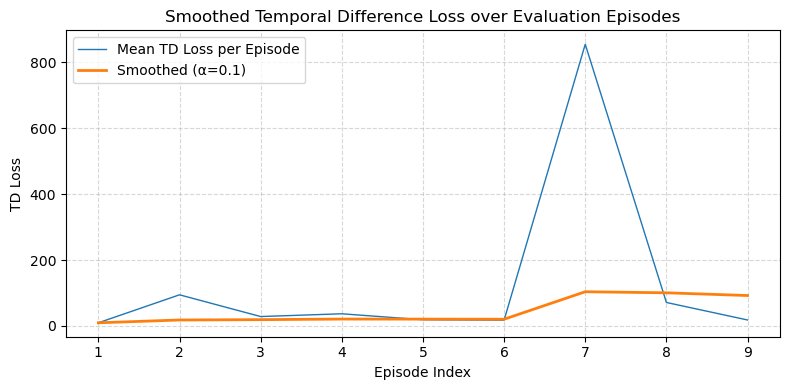

In [18]:
for agent_id, td_loss in results["td_losses"].items():
    succ_td_loss = [td_loss[i] for i in results["successes_idx"][agent_id]]
    plot_td_losses(succ_td_loss, results["successes_idx"][agent_id])